In [16]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import calculate_mse
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


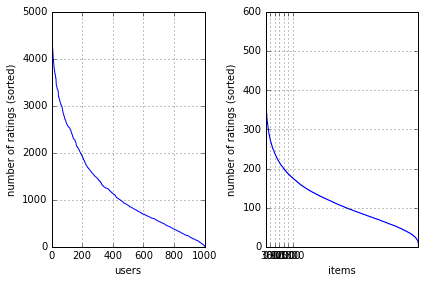

min # of items per user = 8, min # of users per item = 3.


In [5]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data into training and test set

In [17]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # generate random indices
    train = sp.lil_matrix((len(valid_items), len(valid_users)))
    test = sp.lil_matrix((len(valid_items), len(valid_users)))
    index_row,index_col = valid_ratings.nonzero()
    for i in np.arange(len(index_row)):
        # train or test
        choice = np.random.choice(a=[1, 2],p=[0.1,0.9])
        if(choice == 1):
            test[index_row[i],index_col[i]] = valid_ratings[index_row[i],index_col[i]]
        else:
            train[index_row[i],index_col[i]] = valid_ratings[index_row[i],index_col[i]]
    # ***************************************************
    #print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    #print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    #print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [7]:
from plots import plot_train_test_data

valid_ratings, train_validation, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train_validation, test)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1058916
Total number of nonzero elements in test data:117957


## Matrix factorisation using SGD

In [8]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    num_items, num_users = train.shape
    user_features = np.random.randint(low=0, high=5, size= (num_features,num_users))
    item_features = np.random.randint(low=0, high=5, size=(num_items,num_features))
    # ***************************************************
    return 1.0*user_features,1.0*item_features

def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    real_label = np.array([data[d,n] for (d,n) in nz])
    prediction = np.array([(np.dot(item_features[d,:],(user_features[:,n]))) for (d,n) in nz])
    rmse = np.sqrt((1/len(nz))*calculate_mse(real_label,prediction))
    # ***************************************************
    return rmse

In [20]:
def matrix_factorization_SGD(train, test, num_features, lambda_user, lambda_item, gamma):
    """matrix factorization by SGD."""
    # define parameters
    #gamma = 0.01
    #num_features = 10   # K in the lecture notes
    #lambda_user = 0.1
    #lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    #errors = [0]
    learning_curve_train = []
    learning_curve_test = []
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    num_items, num_users = train.shape
    
    #print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        #gamma /= 1.2
        
        for d, n in nz_train:
        # ***************************************************
            prediction = item_features[d,:].dot(user_features[:,n])
            #gradient
            gradient = np.zeros(((num_items + num_users),num_features))
            prediction_error = (train[d,n] - prediction)
            #print(prediction_error)
            #gradient entries for W
            gradient[d,:] = -(prediction_error)*(user_features[:,n].T)
            #gradient entries for Z
            gradient[num_items+n,:] = -(prediction_error)*(item_features[d,:])
            
            #update
            item_features = item_features - gamma*gradient[:num_items,:]
            user_features = user_features - gamma*gradient[num_items:,:].T
            
        train_rmse = compute_error(train, user_features, item_features, nz_train)
        # ***************************************************

        #print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        learning_curve_train.append(train_rmse)
        learning_curve_test.append(compute_error(test, user_features, item_features, nz_test))
        
        # decrease step size
        gamma /= 1.2

    test_rmse = compute_error(test, user_features, item_features, nz_test)
    #print("RMSE on test data: {}.".format(rmse))
    
    return train_rmse, test_rmse, user_features, item_features

## ALS

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    num_items,num_users = train.shape
    num_features = item_features.shape[1]
    user_feature = np.zeros((num_features,num_users))
    for user in np.arange(num_users):
        nnz_items = nnz_items_per_user[user]
        nz_itemindices = nz_user_itemindices[user]
        nz_itemfeatures = item_features[nz_itemindices,:]
        A = ((nz_itemfeatures.T).dot(nz_itemfeatures)+lambda_user*nnz_items*np.eye(num_features))
        train_user = train[nz_itemindices,user].toarray()#[:,0]
        b = ((nz_itemfeatures.T).dot(train_user))[:,0]
        user_feature[:,user] = np.linalg.solve(A,b)
    # ***************************************************
    return user_feature

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    num_items,num_users = train.shape
    num_features = user_features.shape[0]
    item_feature = np.zeros((num_items,num_features))
    for item in np.arange(num_items):
        nnz_users = nnz_users_per_item[item]
        nz_userindices = nz_item_userindices[item]
        nz_userfeatures = user_features[:,nz_userindices]
        A = ((nz_userfeatures).dot(nz_userfeatures.T)+lambda_item*nnz_users*np.eye(num_features))
        train_item = (train[item,nz_userindices].T).toarray()#[:,0]
        b = ((nz_userfeatures).dot(train_item))[:,0]
        item_feature[item,:] = np.linalg.solve(A,b)
    # ***************************************************
    return item_feature

def init_MF_ALS(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    num_items, num_users = train.shape
    user_mean = np.array(train.sum(axis=0)/train.getnnz(axis=0))
    user_features = np.r_[user_mean,np.random.randn(num_features-1,num_users)]
    item_mean = np.array(train.sum(axis=1).T/train.getnnz(axis=1)).T
    item_features = np.c_[item_mean,np.random.randn(num_items,num_features-1)]
    #item_features = np.zeros((num_items,num_features))
    # ***************************************************
    return 1.0*user_features,1.0*item_features

In [ ]:
from helpers import build_index_groups
np.seterr(all='raise') 

def ALS(train, test, num_features, lambda_user, lambda_item):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 10   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    #error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF_ALS(train, num_features)
    
    # ***************************************************
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
    _,nz_user_itemindices = map(list,zip(*nz_col_rowindices))
    nnz_items_per_user = [len(i) for i in nz_user_itemindices]
    _,nz_item_userindices = map(list,zip(*nz_row_colindices))
    nnz_users_per_item = [len(i) for i in nz_item_userindices]
    max_it = 20
    
    print("learn the matrix factorization using SGD...")

    for it in np.arange(max_it):
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        train_rmse = compute_error(train, user_features, item_features, nz_train)
        #print("iter: {}, RMSE on training set: {}.".format(it, rmse))        
        #error_list.append(rmse)
        if abs(error_list[-1]-error_list[-2])<stop_criterion:
            break

    test_rmse = compute_error(test, user_features, item_features, nz_test)
    #print("RMSE on test data: {}.".format(rmse))
    
    return train_rmse, test_rmse, user_features, item_features

## Cross validation

### Number of features

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10         ## K-fold cross validation
gamma = 0.01
num_features_arr = [2 10 20 50 100]   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7

train_rmse_mean = np.zeros(len(num_features_arr))
train_rmse_std = np.zeros(len(num_features_arr))
validation_rmse_mean = np.zeros(len(num_features_arr))
validation_rmse_std = np.zeros(len(num_features_arr))

for i, num_features in enumerate(num_features_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running num_features={n}'.format(n=num_features))
    for k in range(K):
        print('Running {n}th fold'.format(n=k+1))

        ## Splitting data in kth fold
        valid_ratings, training, validation = split_data(train, num_items_per_user, num_users_per_item, 
                                                           min_num_ratings=10, p_test=0.1)
        if method == 0:  ## SGD
            [train_rmse, validation_rmse, user_feature, item_features] = matrix_factorization_SGD(training,
                                                 validation, num_features, lambda_user, lambda_item, gamma) 
        else:            ## ALS
            [train_rmse, validation_rmse, user_feature, item_features] = ALS(training,
                                                    validation, num_features, lambda_user, lambda_item) 
            
        train_rmse_arr.append(train_rmse)
        validation_rmse_arr.append(validation_rmse)
        
    ## Calculate mean and standard deviation    
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(num_features_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(num_features_arr, train_rmse_mean, 'o-', color="r")
plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Number of features (K)'); plt.ylabel('RMSE');
plt.show()

### lambda_user

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user_arr = [0.01, 0.1, 1, 10]
lambda_item = 0.7

train_rmse_mean = np.zeros(len(lambda_user_arr))
train_rmse_std = np.zeros(len(lambda_user_arr))
validation_rmse_mean = np.zeros(len(lambda_user_arr))
validation_rmse_std = np.zeros(len(lambda_user_arr))

for i, lambda_user in enumerate(lambda_user_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    for k in range(K):
        print('Running {n}th fold'.format(n=k+1))

        ## Splitting data in kth fold
        valid_ratings, training, validation = split_data(train, num_items_per_user, num_users_per_item, 
                                                           min_num_ratings=10, p_test=0.1)
        if method == 0:   ## SGD
            [train_rmse, validation_rmse, user_feature, item_features] = matrix_factorization_SGD(training,
                                                    validation, num_features, lambda_user, lambda_item, gamma) 
        else:             ## ALS
            [train_rmse, validation_rmse, user_feature, item_features] = ALS(training,
                                                    validation, num_features, lambda_user, lambda_item) 
            
        train_rmse_arr.append(train_rmse)
        validation_rmse_arr.append(validation_rmse)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda user'); plt.ylabel('RMSE');
plt.show()

### Lambda item

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item_arr = [0.01, 0.1, 0.5, 1]

train_rmse_mean = np.zeros(len(lambda_item_arr))
train_rmse_std = np.zeros(len(lambda_item_arr))
validation_rmse_mean = np.zeros(len(lambda_item_arr))
validation_rmse_std = np.zeros(len(lambda_item_arr))

for i, lambda_item in enumerate(lambda_item_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_item={n}'.format(n=lambda_item))
    for k in range(K):
        print('Running {n}th fold'.format(n=k+1))

        ## Splitting data in kth fold
        valid_ratings, training, validation = split_data(train, num_items_per_user, num_users_per_item, 
                                                           min_num_ratings=10, p_test=0.1)
        if method == 0:   ## SGD
            [train_rmse, validation_rmse, user_feature, item_features] = matrix_factorization_SGD(training,
                                                    validation, num_features, lambda_user, lambda_item, gamma) 
        else:             ## ALS
            [train_rmse, validation_rmse, user_feature, item_features] = ALS(training,
                                                    validation, num_features, lambda_user, lambda_item) 
            
        train_rmse_arr.append(train_rmse)
        validation_rmse_arr.append(validation_rmse)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

### Learning rate

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD
K = 10        ## K-fold cross validation
gamma_arr = [0.01 0.1 1]
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.5

train_rmse_mean = np.zeros(len(gamma_arr))
train_rmse_std = np.zeros(len(gamma_arr))
validation_rmse_mean = np.zeros(len(gamma_arr))
validation_rmse_std = np.zeros(len(gamma_arr))

for i, gamma in enumerate(gamma_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running gamma={n}'.format(n=gamma))
    for k in range(K):
        print('Running {n}th fold'.format(n=k+1))

        ## Splitting data in kth fold
        valid_ratings, training, validation = split_data(train, num_items_per_user, num_users_per_item, 
                                                           min_num_ratings=10, p_test=0.1)
        if method == 0:   ## SGD
            [train_rmse, validation_rmse, user_feature, item_features] = matrix_factorization_SGD(training,
                                                    validation, num_features, lambda_user, lambda_item, gamma) 
        #else:
        #    [train_rmse, validation_rmse, user_feature, item_features] = ALS(train,
        #                                            validation, num_features, lambda_user, lambda_item) 
            
        train_rmse_arr.append(train_rmse)
        validation_rmse_arr.append(validation_rmse)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(gamma_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(gamma_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(gamma_arr, train_rmse_mean, 'o-', color="r")
plt.plot(gamma_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Learning Rate'); plt.ylabel('RMSE');
plt.show()

### TODO
#### 1. Compare SGD, ALS with the best set of parameters (based on above results)